# 模仿学习

教程链接：[模仿学习](https://hrl.boyuai.com/chapter/3/%E6%A8%A1%E4%BB%BF%E5%AD%A6%E4%B9%A0)

模仿学习（imitation learning）假设存在一个专家智能体，其策略可以看成最优策略，我们就可以直接模仿这个专家在环境中交互的状态动作数据来训练一个策略，并且不需要用到环境提供的奖励信号。目前学术界模仿学习的方法基本上可以分为 3 类：
1. 行为克隆（behavior cloning，BC）
2. 逆强化学习（inverse RL）
3. 生成式对抗模仿学习（generative adversarial imitation learning，GAIL）

In [1]:
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils

## 0. 生成专家数据

首先，我们需要有一定量的专家数据，为此，预先通过 PPO 算法训练出一个表现良好的专家模型，再利用专家模型生成专家数据。

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class PPO(rl_utils.BasePolicy):
    ''' PPO算法,采用截断方式 '''
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, 
            actor_lr:float, critic_lr:float, lmbda:float, 
            epochs:int, eps:float, gamma:float, device:torch.device
        ):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state:np.ndarray) -> int:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'],
                        dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                        dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                        dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                        dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(
                        self.gamma, self.lmbda, td_delta.cpu()
                    ).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                            F.mse_loss(self.critic(states), td_target.detach())
                        )
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [6]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 9: 100%|██████████| 50/50 [00:05<00:00,  8.77it/s, episode=500, return=200.000]


In [7]:
def sample_expert_data(n_episode:int, expert_agent:rl_utils.BasePolicy):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = expert_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)


env.seed(0)
torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode, ppo_agent)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

## 1. 行为克隆 (BC)

行为克隆（BC）就是直接使用监督学习方法，将专家数据中的$s_t$看作样本输入，$a_t$视为标签。若动作是离散的，该损失函数可以是**最大似然估计**得到的。若动作是连续的，该损失函数可以是均方误差函数。

在训练数据量比较大的时候，BC 能够很快地学习到一个不错的策略。例如，围棋人工智能 AlphaGo 就是首先在 16 万盘棋局的 3000 万次落子数据中学习人类选手是如何下棋的，仅仅凭这个行为克隆方法，AlphaGo 的棋力就已经超过了很多业余围棋爱好者。由于 BC 的实现十分简单，因此在很多实际场景下它都可以作为策略预训练的方法。

BC 也存在很大的局限性，该局限在数据量比较小的时候犹为明显。具体来说，由于通过 BC 学习得到的策略只是拿小部分专家数据进行训练，因此 BC 只能在专家数据的状态分布下预测得比较准。然而，强化学习面对的是一个序贯决策问题，通过 BC 学习得到的策略在和环境交互过程中不可能完全学成最优，只要存在一点偏差，就有可能导致下一个遇到的状态是在专家数据中没有见过的。此时，由于没有在此状态（或者比较相近的状态）下训练过，策略可能就会随机选择一个动作，这会导致下一个状态进一步偏离专家策略遇到的的数据分布。最终，该策略在真实环境下不能得到比较好的效果，这被称为行为克隆的**复合误差**（compounding error）问题。

In [8]:
class BehaviorClone:
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, lr:float
        ):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states:np.ndarray, actions:np.ndarray):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state:torch.Tensor) -> int:
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

In [9]:
def test_agent(
        agent:BehaviorClone, env:gym.Env, n_episode:int
    ) -> np.ndarray:
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

In [10]:
env.seed(0)
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(
                            low=0, high=expert_s.shape[0], size=batch_size
                        )
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 1000/1000 [02:29<00:00,  6.67it/s, return=40.580]


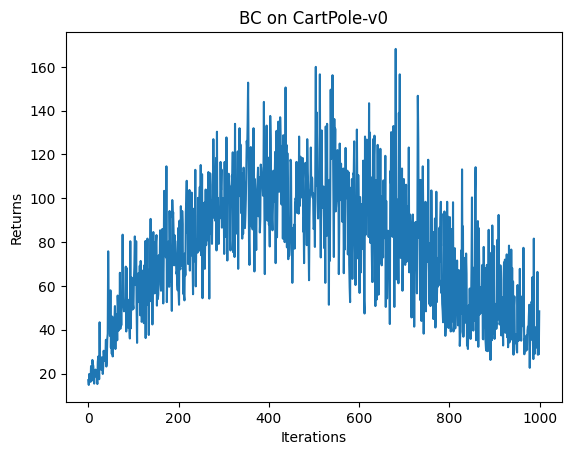

In [11]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

我们发现 BC 无法学习到最优策略，这主要是因为在数据量比较少的情况下，学习容易发生过拟合。

## 2. 生成式对抗模仿学习 (GAIL)

GAIL 实质上是模仿了专家策略的**占用度量**，即尽量使得策略在环境中的所有状态动作对的占用度量和专家策略的占用度量一致。为了达成这个目标，策略需要和环境进行交互，收集下一个状态的信息并进一步做出动作。这一点和 BC 不同，BC 完全不需要和环境交互。

GAIL 算法中有一个判别器和一个策略，策略就相当于是生成式对抗网络中的**生成器**（generator），给定一个状态，策略会输出这个状态下应该采取的动作，而**判别器**（discriminator）将状态动作对作为输入，输出一个 0 到 1 之间的实数，表示判别器认为该状态动作对是来自智能体策略而非专家的概率。判别器的目标是尽量将专家数据的输出靠近 0，将模仿者策略的输出靠近 1，这样就可以将两组数据分辨开来。

有了判别器之后，模仿者策略的目标就是其交互产生的轨迹能被判别器误认为专家轨迹。于是，我们可以用判别器的输出来作为奖励函数来训练模仿者策略。具体来说，若模仿者策略在环境中采样到状态$s$，并且采取动作$a$，此时该状态动作对$(s,a)$会输入到判别器$D$中，输出$D(s,a)$的值，然后将奖励设置为$r(s,a)=-\log D(s,a)$。

In [12]:
class Discriminator(nn.Module):
    """
    判别器模型。模型输入为一个状态动作对，输出一个概率标量。
    """
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor, a:torch.Tensor) -> torch.Tensor:
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))

In [13]:
class GAIL:
    def __init__(self, 
            agent:rl_utils.BasePolicy, 
            state_dim:int, action_dim:int, hidden_dim:int, lr_d:float
        ):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), 
                                            lr=lr_d)
        self.agent = agent

    def learn(self, 
            expert_s:np.ndarray, expert_a:np.ndarray, 
            agent_s:np.ndarray, agent_a:np.ndarray, next_s:np.ndarray, dones:np.ndarray
        ):
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a).to(device)
        agent_states = torch.tensor(agent_s, dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_a).to(device)
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)
                        ) + nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)

每一轮迭代中，GAIL 中的策略和环境交互，采样新的状态动作对。基于专家数据和策略新采样的数据，首先训练判别器，然后将判别器的输出转换为策略的奖励信号，指导策略用 PPO 算法做训练。

In [16]:
env.seed(0)
torch.manual_seed(0)
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(
            expert_s, expert_a, np.array(state_list), np.array(action_list),
            np.array(next_state_list), np.array(done_list)
        )
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 500/500 [01:01<00:00,  8.10it/s, return=200.000]


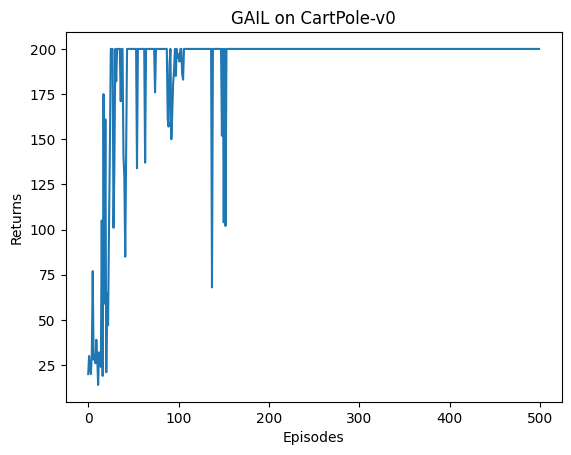

In [15]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

在数据样本有限的情况下，BC 不能学习到最优策略，但是 GAIL 在相同的专家数据下可以取得非常好的结果。这一方面归因于 GAIL 的训练目标（拉近策略和专家的占用度量）十分贴合模仿学习任务的目标，避免了 BC 中的复合误差问题；另一方面得益于 GAIL 训练中，策略可以和环境交互出更多的数据，以此训练判别器，进而生成对基于策略“量身定做”的指导奖励信号。